## CANYON-MED 
Implementation following the instruction of the article *'A Regional Neural Network Approach to  estimate Water-COlumn Nutrient COncentrations and Carbonate System Variables in the Mediterranean Sea: CANYON-MED'*

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from blitz.modules import BayesianLinear
from IPython import display
from torchvision import datasets, transforms
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib import pyplot as plt

In [11]:
set_default()

Definition of a function that counts the number of parameters.

In [12]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
datatest=torch.zeros(10,9)

#print("Shapes:")
#print("X:", tuple(data.size()))
#print("y:", tuple(target.size()))

**Raws** = number of samples

**Columns** = number of input for samples

In [17]:
data = torch.unsqueeze(torch.linspace(0, 1, 101), dim=1)

In [7]:
target = data.pow(3) + 0.03 * torch.rand(data.size()).to(device) 

print("Shapes:")
print("data:", tuple(data.size()))
print("target:", tuple(target.size()))

Shapes:
data: (101, 1)
target: (101, 1)


The input data were normalized to hace an average of zero and a standard deviation of one using the mean and the standard deviation of the training data.

In [16]:
def normalization_fun(data):
    mean=data.mean()
    std=data.std()
    data=(data-mean)/std
    return data

### INPUT PREPARATION OF THE DATA
**Input**: time(year+date), latitude, longitude, temperature, psaline, doxy

**Output**: CT (=total carbon)

In [22]:
def prep_dataset(data):
    data.T[2]=datatest.T[2]/90                                                           #latitude [-90,90]/90
    data.T[4]=datatest.T[4]/20000 + 1 / (1+np.exp(-(datatest.T[4])/300))**3              #pressure
    data.T[8]=data.T[0]
    data.T[0]=np.cos(data.T[1]*np.pi/(365/2))
    data.T[1]=np.sin(data.T[1]*np.pi/(365/2))
    return data

In [28]:
i=1 #input number
best_topo_all=[[i,18,13,1],[i,20,8,1],[i,31,23,1],[i,35,21,1],[i,35,9,1],[i,36,21,1],[i,39,26,1],[i,44,27,1],[i,47,21,1],[i,47,29,1]]

In [30]:
def top_select(best_topo_all, n):
    best_topo=best_topo_all[0:n]
    return best_topo  

top_select(best_topo_all,4)

[[1, 18, 13, 1], [1, 20, 8, 1], [1, 31, 23, 1], [1, 35, 21, 1]]

Creation of the specific sigmoid function

In [31]:
A=4/3
a=1.7159
def mysigmoid(x):
    return A*torch.sigmoid(x*a/2) 

class MySigmoid(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return mysigmoid(x)
        
activation_function = MySigmoid() 

### DEFINITION OF THE MODEL
Multi-layered percepton with Bayesian regularization.

In [32]:
class MLP_Bayesian(nn.Module):
    def __init__(self, top):
        input_size, n_hidden1, n_hidden2, output_size = best_topo[top]
        super( MLP_Bayesian , self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            BayesianLinear(input_size, n_hidden1), 
            activation_function, 
            BayesianLinear(n_hidden1, n_hidden2), 
            activation_function, 
            BayesianLinear(n_hidden2, output_size), 
            activation_function
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    

In [35]:
accuracy_list = []
def train(model, ep):
    
    for t in range(ep):
        
        output = model(data)
        criterion=torch.nn.MSELoss()                                        #criterion=torch.nn.L1Loss()
        loss = criterion(output, target)
        
        print(f"[MODEL]: {top+1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### TRAINING OF THE MODEL 
Using the MLP defined above with Bayesian regularization and an Adam optimizer

In [37]:
models=list()
models_loss=[]
epoch=1000
for top in range(len(best_topo)):
    model_mlp=MLP_Bayesian(top)
    models.append(model_mlp)
    optimizer = optim.Adam(model_mlp.parameters(), lr=0.01) #, momentum=0.5)
    train(model_mlp, epoch)

[MODEL]: 4, [EPOCH]: 999, [LOSS]: 0.000107


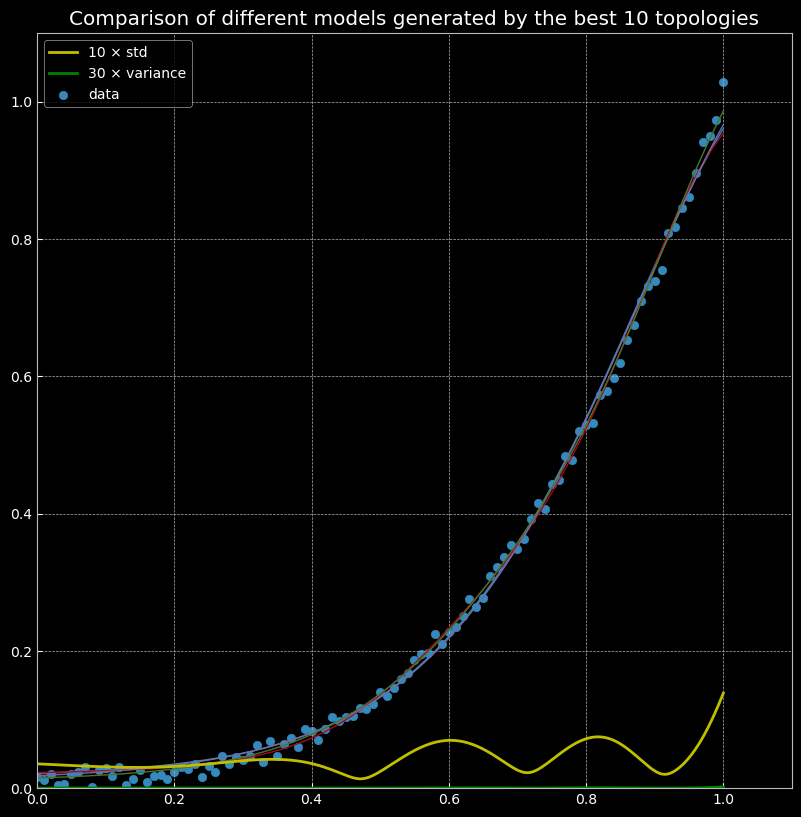

In [70]:
y_pred = list()
X_new = torch.unsqueeze(torch.linspace(0, 1, 1001), dim=1).to(device)
def dense_prediction(models, zoom):
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), lw=1)
        
    plt.scatter(data.cpu().numpy(), target.cpu().numpy(), label='data')
    plt.axis('square')
    plt.axis(torch.tensor((0, 1.1, 0, 1.1)) * zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
    plt.legend()
    plt.title('Comparison of different models generated by the best 10 topologies')
    
z = 1  # try 1 or 4
dense_prediction(models, zoom=z)

### LINEAR COMBINATION OF THE BEST 10 OUTPUTS

Text(0.5, 1.0, 'Final solution (average of the solution given by 10 best topology)')

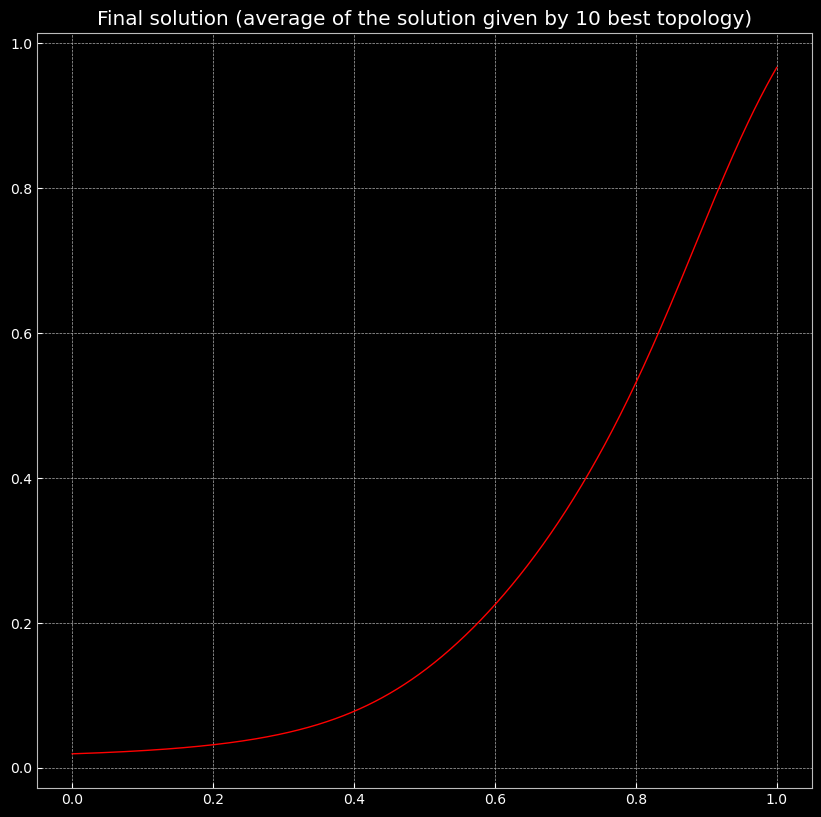

In [72]:
def ct_result(my_input):
    outputs=[]
    for top in range(len(best_topo)):
        my_model=models[top]
        my_output=my_model(my_input)
        outputs.append(my_output)
    out=sum(outputs)/len(outputs)
    return out

out=ct_result(X_new)
plt.plot(X_new.cpu().numpy(), out.detach().numpy(), 'r-', lw=1)
plt.title('Final solution (average of the solution given by 10 best topology)')

In [19]:
my_in=torch.tensor([0.5])

In [20]:
ct=ct_result(my_in).item()
print('valore predetto:', ct)

valore predetto: 0.13545380532741547


In [21]:
my_in.item()**3

0.125